In [540]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from itertools import cycle
from scipy.stats import kruskal



np.random.seed(42)

In [541]:
start_data, end_data = datetime(2022,6,1),datetime(2022,8,1)
df = pd.DataFrame({'date': [start_data + timedelta(days=i) for i in range((end_data - start_data).days + 1)]})
# to generate around these values +- 10 % 
value_intervals = {0: 650, 1: 720, 2: 1600, 3: 1500, 4: 2200, 5: 2200, 6: 1400}
# income of company to start from it to  generate random num of tables and income for every waiter, will be deleted
df['fake_income'] = df['date'].dt.weekday.map(lambda x: np.random.uniform(value_intervals[x] * 0.9,value_intervals[x] * 1.1)).map(\
    lambda x: round(x,2))
df['day_of_week'] = df['date'].dt.weekday
waiters_shifts = [cycle([1, 1, 0, 0]), cycle([0, 1, 1, 0]), cycle([0, 0, 1, 1]), cycle([1, 0, 0, 1])]

# creating work shifts as 1 working day 0 not
for i in range(4):
    df['work_shif_w_{}'.format(i)] = [next(waiters_shifts[i]) for _ in range(len(df))]
    
# in the shift 2 waiters, fake income/2 if waiter works
for i in range(4):
    df['work_shif_w_{}'.format(i)] = df.apply(lambda row: row['fake_income'] / 2 if row['work_shif_w_{}'.format(i)] != 0 else 0, axis=1)
    
# to give them a bit of random chaos in income +- 10 %
for i in range(4):
    df['work_shif_w_{}'.format(i)] = df['work_shif_w_{}'.format(i)].apply(lambda x: round(np.random.uniform(x*0.9, x*1.1),2))

df.drop(['fake_income','day_of_week' ], axis = 1, inplace = True)

# to generate tables for every waiter with average bill is 26 EUR
for i in range(4):
    df['tables_waiter_{}'.format(i)] = df['work_shif_w_{}'.format(i)].apply(lambda x: round(x/26))

# to generate new average bill
for i in range(4):
    df['average_bill_w_{}'.format(i)] = df.apply(lambda row, i=i: row['work_shif_w_{}'.format(i)] /\
        row['tables_waiter_{}'.format(i)] if row['work_shif_w_{}'.format(i)] != 0 else 0, axis=1).map(lambda x: round(x,2))

# 3rd waiter has bigger average bill 0-10%
df['average_bill_w_2'] = df['average_bill_w_2'].apply(lambda x: round(np.random.uniform(x, x*1.1),2))
df['work_shif_w_2'] = df['average_bill_w_2'] * df['tables_waiter_2']

# 4th waiter has bigger average bill 5-15%
df['average_bill_w_3'] = df['average_bill_w_3'].apply(lambda x: round(np.random.uniform(x*1.05, x*1.15),2))
df['work_shif_w_3'] = df['average_bill_w_3'] * df['tables_waiter_3']

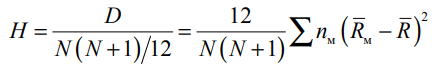, criteria kruskall wallis equal to $χ^2$, if groups not too small else use their tables

In [542]:
from scipy.stats import kruskal

calculation_list = ['work_shif_w_', 'tables_waiter_', 'average_bill_w_']
interpirtation = {'work_shif_w_':'income','tables_waiter_':'table','average_bill_w_':'average_bill'}
days_of_week_dict = {0: 'Monday',1: 'Tuesday',2: 'Wednesday',
                    3: 'Thursday',4: 'Friday',5: 'Saturday', 6: 'Sunday'}



# I will have 7 experiments: Monday - Sunday and 4 waiters (groups) and 3 calculations = 28 experements
for i in range(7): # 7 days
    for j in range(3): # 3 calculation(income, average, tables)
        list_of_values_per_waiter = [] # list [day,calculation type, waiter, his list by filter]
        for z in range(4): # by waiters
            # to get list from folter day calculation and waiter
            x = df[(df[calculation_list[j] + str(z)] != 0) & (df['date'].dt.weekday == i)][calculation_list[j] + str(z)].tolist()
            list_of_values_per_waiter.append(x)    
            
            
            
        statistic, p_value = kruskal(*list_of_values_per_waiter)
        print('For',days_of_week_dict[i], ", Calculation via", interpirtation[calculation_list[j]],", Statistic:", round(statistic,2),", p-value:", round(p_value,2))

For Monday , Calculation via income , Statistic: 2.43 , p-value: 0.49
For Monday , Calculation via table , Statistic: 0.77 , p-value: 0.86
For Monday , Calculation via average_bill , Statistic: 10.22 , p-value: 0.02
For Tuesday , Calculation via income , Statistic: 9.4 , p-value: 0.02
For Tuesday , Calculation via table , Statistic: 2.59 , p-value: 0.46
For Tuesday , Calculation via average_bill , Statistic: 9.75 , p-value: 0.02
For Wednesday , Calculation via income , Statistic: 12.48 , p-value: 0.01
For Wednesday , Calculation via table , Statistic: 10.47 , p-value: 0.01
For Wednesday , Calculation via average_bill , Statistic: 12.22 , p-value: 0.01
For Thursday , Calculation via income , Statistic: 3.06 , p-value: 0.38
For Thursday , Calculation via table , Statistic: 0.54 , p-value: 0.91
For Thursday , Calculation via average_bill , Statistic: 9.92 , p-value: 0.02
For Friday , Calculation via income , Statistic: 9.63 , p-value: 0.02
For Friday , Calculation via table , Statistic: 6